# Imports


In [1]:
# import find_context from baselines/bm25/bm25.py
import random
from urllib import parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
from tqdm import tqdm

# Helpful Functions


In [2]:
def compute_mrr(rankings, k_values=[1, 5, 10]):
    mrr_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    mrr_at_k_lists = {str(k): [0 for _ in range(500)] for k in k_values}
    # compute MRR for each k
    # and compute confidence intervals for each k
    mrr_at_max = {'score': 0, 'cl': [None, None]}
    mrr_at_max_list = [0 for _ in range(500)]
    
    # extract 500 samples
    for i in range(500):
        sample = np.array(random.choices(rankings, k = len(rankings)))
        for k in mrr_at_k_lists.keys():
            # get all the elements in sample where rank <= k
            sample_k = sample[sample <= int(k)]
            if len(sample_k) > 0:
                mrr_at_k_lists[str(k)][i] = np.sum(1 / sample_k) / len(sample)
        mrr_at_max_list[i] = np.mean(1 / sample)
    
    # sort values for confidence intervals
    for k in mrr_at_k_lists.keys():
        mrr_at_k_lists[str(k)].sort()
    mrr_at_max_list.sort()
        
    # find mean score and 90% confidence interval
    for k in mrr_at_k_lists.keys():
        mrr_at_k[str(k)]['score'] = np.mean(mrr_at_k_lists[str(k)]) * 1000 // 1 / 1000
        mrr_at_k[str(k)]['cl'] = [mrr_at_k_lists[str(k)][int(0.025 * len(mrr_at_k_lists[str(k)]))],
                                  mrr_at_k_lists[str(k)][int(0.975 * len(mrr_at_k_lists[str(k)]))]]
    mrr_at_max['score'] = np.mean(mrr_at_max_list) * 1000 // 1 / 1000
    mrr_at_max['cl'] = [mrr_at_max_list[int(0.025 * len(mrr_at_max_list))],
                        mrr_at_max_list[int(0.975 * len(mrr_at_max_list))]]

    
    # add max to mrr_at_k
    mrr_at_k['max'] = mrr_at_max

    return mrr_at_k

In [3]:
def compute_stratified_mrr(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in zip(rankings, categories):
        ranks_stratified[category].append(rank)
        
    discrete_mrr_at_k = {}
        
    for category in categories_values:
        discrete_mrr_at_k[category] = compute_mrr(ranks_stratified[category], k_values)
        
    return discrete_mrr_at_k

In [4]:
def compute_hits(rankings, k_values=[1, 5, 10]):
    hits_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    hits_at_k_lists = {str(k): [0 for _ in range(500)] for k in k_values}
    
    # extract 100 samples
    for i in range(500):
        sample = np.array(random.choices(rankings, k = len(rankings)))
        for k in hits_at_k_lists.keys():
            hits_at_k_lists[str(k)][i] = np.sum(sample <= int(k)) / len(sample)
    
    # sort values for confidence intervals
    for k in hits_at_k_lists.keys():
        hits_at_k_lists[str(k)].sort()
    
    # find mean score and 90% confidence interval
    for k in hits_at_k_lists.keys():
        hits_at_k[str(k)]['score'] = np.mean(hits_at_k_lists[str(k)]) * 1000 // 1 / 1000
        hits_at_k[str(k)]['cl'] = [hits_at_k_lists[str(k)][int(0.025 * len(hits_at_k_lists[str(k)]))],
                                  hits_at_k_lists[str(k)][int(0.975 * len(hits_at_k_lists[str(k)]))]]
    
    return hits_at_k

In [5]:
def compute_stratified_hits(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in zip(rankings, categories):
        ranks_stratified[category].append(rank)
    
    discrete_hits_at_k = {}
        
    for category in categories_values:
        discrete_hits_at_k[category] = compute_hits(ranks_stratified[category], k_values)
        
    return discrete_hits_at_k

In [6]:
def compute_ndcg(rankings, k_values=[1, 5, 10]):
    ndcg_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    ndcg_at_k_lists = {str(k): [0 for _ in range(500)] for k in k_values}
    # compute NDCG for each k
    # and compute confidence intervals for each k
    ndcg_at_max = {'score': 0, 'cl': [None, None]}
    ndcg_at_max_list = [0 for _ in range(500)]
    
    # extract 100 samples
    for i in range(500):
        sample = np.array(random.choices(rankings, k = len(rankings)))
        for k in ndcg_at_k_lists.keys():
            # get all the elements in sample where rank <= k
            sample_k = sample[sample <= int(k)]
            if len(sample_k) > 0:
                ndcg_at_k_lists[str(k)][i] = np.sum(1 / np.log2(sample_k + 1)) / len(sample)
        ndcg_at_max_list[i] = np.sum(1 / np.log2(sample + 1)) / len(sample)
    
    # sort values for confidence intervals
    for k in ndcg_at_k_lists.keys():
        ndcg_at_k_lists[str(k)].sort()
    ndcg_at_max_list.sort()
        
    # find mean score and 90% confidence interval
    for k in ndcg_at_k_lists.keys():
        ndcg_at_k[str(k)]['score'] = np.mean(ndcg_at_k_lists[str(k)]) * 1000 // 1 / 1000
        ndcg_at_k[str(k)]['cl'] = [ndcg_at_k_lists[str(k)][int(0.025 * len(ndcg_at_k_lists[str(k)]))],
                                  ndcg_at_k_lists[str(k)][int(0.975 * len(ndcg_at_k_lists[str(k)]))]]
    ndcg_at_max['score'] = np.mean(ndcg_at_max_list) * 1000 // 1 / 1000
    ndcg_at_max['cl'] = [ndcg_at_max_list[int(0.025 * len(ndcg_at_max_list))],
                        ndcg_at_max_list[int(0.975 * len(ndcg_at_max_list))]]
    
    # add max to ndcg_at_k
    ndcg_at_k['max'] = ndcg_at_max
    
    return ndcg_at_k

In [7]:
def compute_stratified_ndcg(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in zip(rankings, categories):
        ranks_stratified[category].append(rank)
    
    discrete_ndcg_at_k = {}
        
    for category in categories_values:
        discrete_ndcg_at_k[category] = compute_ndcg(ranks_stratified[category], k_values)
        
    return discrete_ndcg_at_k

# Load data


In [8]:
dfs = {}
# use glob to select all files in test_data/ that don't include "mention_map"
files = glob('test_data/*')
files = [file for file in files if 'mention_map' not in file]
for file in files:
    basename = os.path.basename(file)
    lang = basename.split('.')[0]
    if lang == 'ps':
        continue
    dfs[lang] = pd.read_parquet(file)
    dfs[lang]['missing_category'] = dfs[lang]['missing_category'].fillna('present')
    dfs[lang]['number_candidates'] = dfs[lang]['negative_contexts'].apply(lambda x: x.count("'context'") + 1)

In [9]:
dfs['simple']

,source_title,source_ID,target_title,context,section,mention_present,source_lead,first_version,second_version,direct_match,...,random_rank,bm25_mentions_rank,fuzzy_match_rank,roberta_full_multilingual,roberta_simple_multilingual,roberta_best_simple,roberta_full_multilingual_small,roberta_full_simple,roberta_simple_simple,number_candidates
0,Fundamentalno.rf,1049956,Moscow_Oblast,"Company Group ""Fundamental.RF"" (Russian: Групп...",Lead,False,"Company Group ""Fundamental.RF"" (Russian: Групп...",9097139,9140676,True,...,4,1,1,1,1,1,1,1,1,9
1,List_of_ufologists,1057571,Paul_Hellyer,"This is a list of people, sorted by their date...",Lead,False,"This is a list of people, sorted by their date...",9153435,9153441,True,...,1,1,1,1,1,1,1,1,1,2
2,List_of_ufologists,1057571,Jim_Marrs,"This is a list of people, sorted by their date...",Lead,False,"This is a list of people, sorted by their date...",9153435,9153441,True,...,1,2,2,1,1,1,1,1,1,2
3,Patricia_Greene,818327,Medical_drama,She is the long-standing voice of Jill Archer ...,Career,False,Patricia Honor Richardson MBE (née Greene; bor...,9126260,9126268,False,...,20,15,14,1,15,1,1,1,17,22
4,Fuchs%27_dystrophy,1056217,Disease,I.,Lead,False,I. Introduction\n- Briefly explain Fuchs' dyst...,9142989,9146121,False,...,7,3,1,1,8,1,1,1,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Hymn,44117,Bible,A hymn is a religious song of worship in Chris...,Lead,False,A hymn is a religious song of worship in Chris...,7894022,9132706,False,...,2,1,2,1,1,1,1,1,1,2
996,Lorne_Balfe,1033552,Bruce_Broughton,Influences\nBalfe stated composers like Hans Z...,Influences,False,Lorne Balfe (born 23 February 1976) is a Scott...,8990063,9052466,True,...,3,2,1,1,1,1,1,1,2,3
997,Narges_Mohammadi,1052532,Gender,"In 2023, she won the Nobel Peace Prize for ""he...",Human rights,True,Narges Mohammadi (Persian: نرگس محمدی) is an I...,9134843,9135709,True,...,37,1,1,1,1,1,1,1,1,38
998,Amie_Doherty,1048917,Los_Angeles,Career\nBefore moving to the United States of ...,Career,True,Amie Doherty (Born 1994) is an Irish composer ...,9086147,9091813,True,...,1,2,1,1,1,1,1,1,1,2


In [10]:
for key in dfs:
    print(key, dfs[key].columns)

ms Index(['source_title', 'source_ID', 'target_title', 'context', 'section',
       'mention_present', 'source_lead', 'first_version', 'second_version',
       'direct_match', 'missing_category', 'negative_contexts',
       'current_links', 'target_lead', 'random_rank', 'bm25_mentions_rank',
       'fuzzy_match_rank', 'roberta_full_multilingual',
       'roberta_simple_multilingual', 'roberta_full_multilingual_small',
       'roberta_full_ms', 'roberta_simple_ms', 'number_candidates'],
      dtype='object')
sk Index(['source_title', 'source_ID', 'target_title', 'context', 'section',
       'mention_present', 'source_lead', 'first_version', 'second_version',
       'direct_match', 'missing_category', 'negative_contexts',
       'current_links', 'target_lead', 'random_rank', 'bm25_mentions_rank',
       'fuzzy_match_rank', 'roberta_full_multilingual',
       'roberta_simple_multilingual', 'roberta_full_multilingual_small',
       'roberta_full_sk', 'roberta_simple_sk', 'number_candidates

## Compute Metrics

In [11]:
columns = ['random_rank', 'bm25_mentions_rank',	'fuzzy_match_rank']
partial_matches = ['roberta']

In [12]:
mrr_at_k = {}
for lang in tqdm(dfs):
    mrr_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            try:
                mrr_at_k[lang][column] = compute_mrr(dfs[lang][column].tolist())
            except:
                pass
        for partial_match in partial_matches:
            if partial_match in column:
                try:
                    mrr_at_k[lang][column] = compute_mrr(dfs[lang][column].tolist())
                except:
                    pass

100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


In [13]:
stratified_mrr_at_k = {}
for lang in tqdm(dfs):
    stratified_mrr_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            try:
                stratified_mrr_at_k[lang][column] = compute_stratified_mrr(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())
            except:
                pass
        for partial_match in partial_matches:
            if partial_match in column:
                try:
                    stratified_mrr_at_k[lang][column] = compute_stratified_mrr(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())
                except:
                    pass

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


In [14]:
hits_at_k = {}
for lang in tqdm(dfs):
    hits_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            try:
                hits_at_k[lang][column] = compute_hits(dfs[lang][column].tolist())
            except:
                pass
        for partial_match in partial_matches:
            if partial_match in column:
                try:
                    hits_at_k[lang][column] = compute_hits(dfs[lang][column].tolist())
                except:
                    pass

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


In [15]:
stratified_hits_at_k = {}
for lang in tqdm(dfs):
    stratified_hits_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            try:
                stratified_hits_at_k[lang][column] = compute_stratified_hits(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())
            except:
                pass
        for partial_match in partial_matches:
            if partial_match in column:
                try:
                    stratified_hits_at_k[lang][column] = compute_stratified_hits(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())
                except:
                    pass

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


In [16]:
ndcg_at_k = {}
for lang in tqdm(dfs):
    ndcg_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            try:
                ndcg_at_k[lang][column] = compute_ndcg(dfs[lang][column].tolist())
            except:
                pass
        for partial_match in partial_matches:
            if partial_match in column:
                try:
                    ndcg_at_k[lang][column] = compute_ndcg(dfs[lang][column].tolist())
                except:
                    pass

100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


In [17]:
stratified_ndcg_at_k = {}
for lang in tqdm(dfs):
    stratified_ndcg_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            try:
                stratified_ndcg_at_k[lang][column] = compute_stratified_ndcg(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())
            except:
                pass
        for partial_match in partial_matches:
            if partial_match in column:
                try:
                    stratified_ndcg_at_k[lang][column] = compute_stratified_ndcg(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())
                except:
                    pass

100%|██████████| 20/20 [00:44<00:00,  2.21s/it]


In [18]:
std = {}
for lang in tqdm(dfs):
    std[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            std[lang][column] = dfs[lang][column].std()
        for partial_match in partial_matches:
            if partial_match in column:
                std[lang][column] = dfs[lang][column].std()

100%|██████████| 20/20 [00:00<00:00, 1124.45it/s]


In [19]:
stratified_std = {}
for lang in tqdm(dfs):
    stratified_std[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            stratified_std[lang][column] = dfs[lang][column].groupby(dfs[lang]['missing_category']).std()
        for partial_match in partial_matches:
            if partial_match in column:
                stratified_std[lang][column] = dfs[lang][column].groupby(dfs[lang]['missing_category']).std()

100%|██████████| 20/20 [00:00<00:00, 200.38it/s]


# Plot results

In [ ]:
# set matplotlib params
plt.rcParams.update({'font.size': 15})
# set marker size
markersize = 7

## Plot aggregated results

## Multilingual vs Monolingual

In [ ]:
columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank']
labels = ['Random', 'BM25', 'String Match', ]
markers = ['o', 'v', 's']
colours = ['C0', 'C1', 'C2']
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']

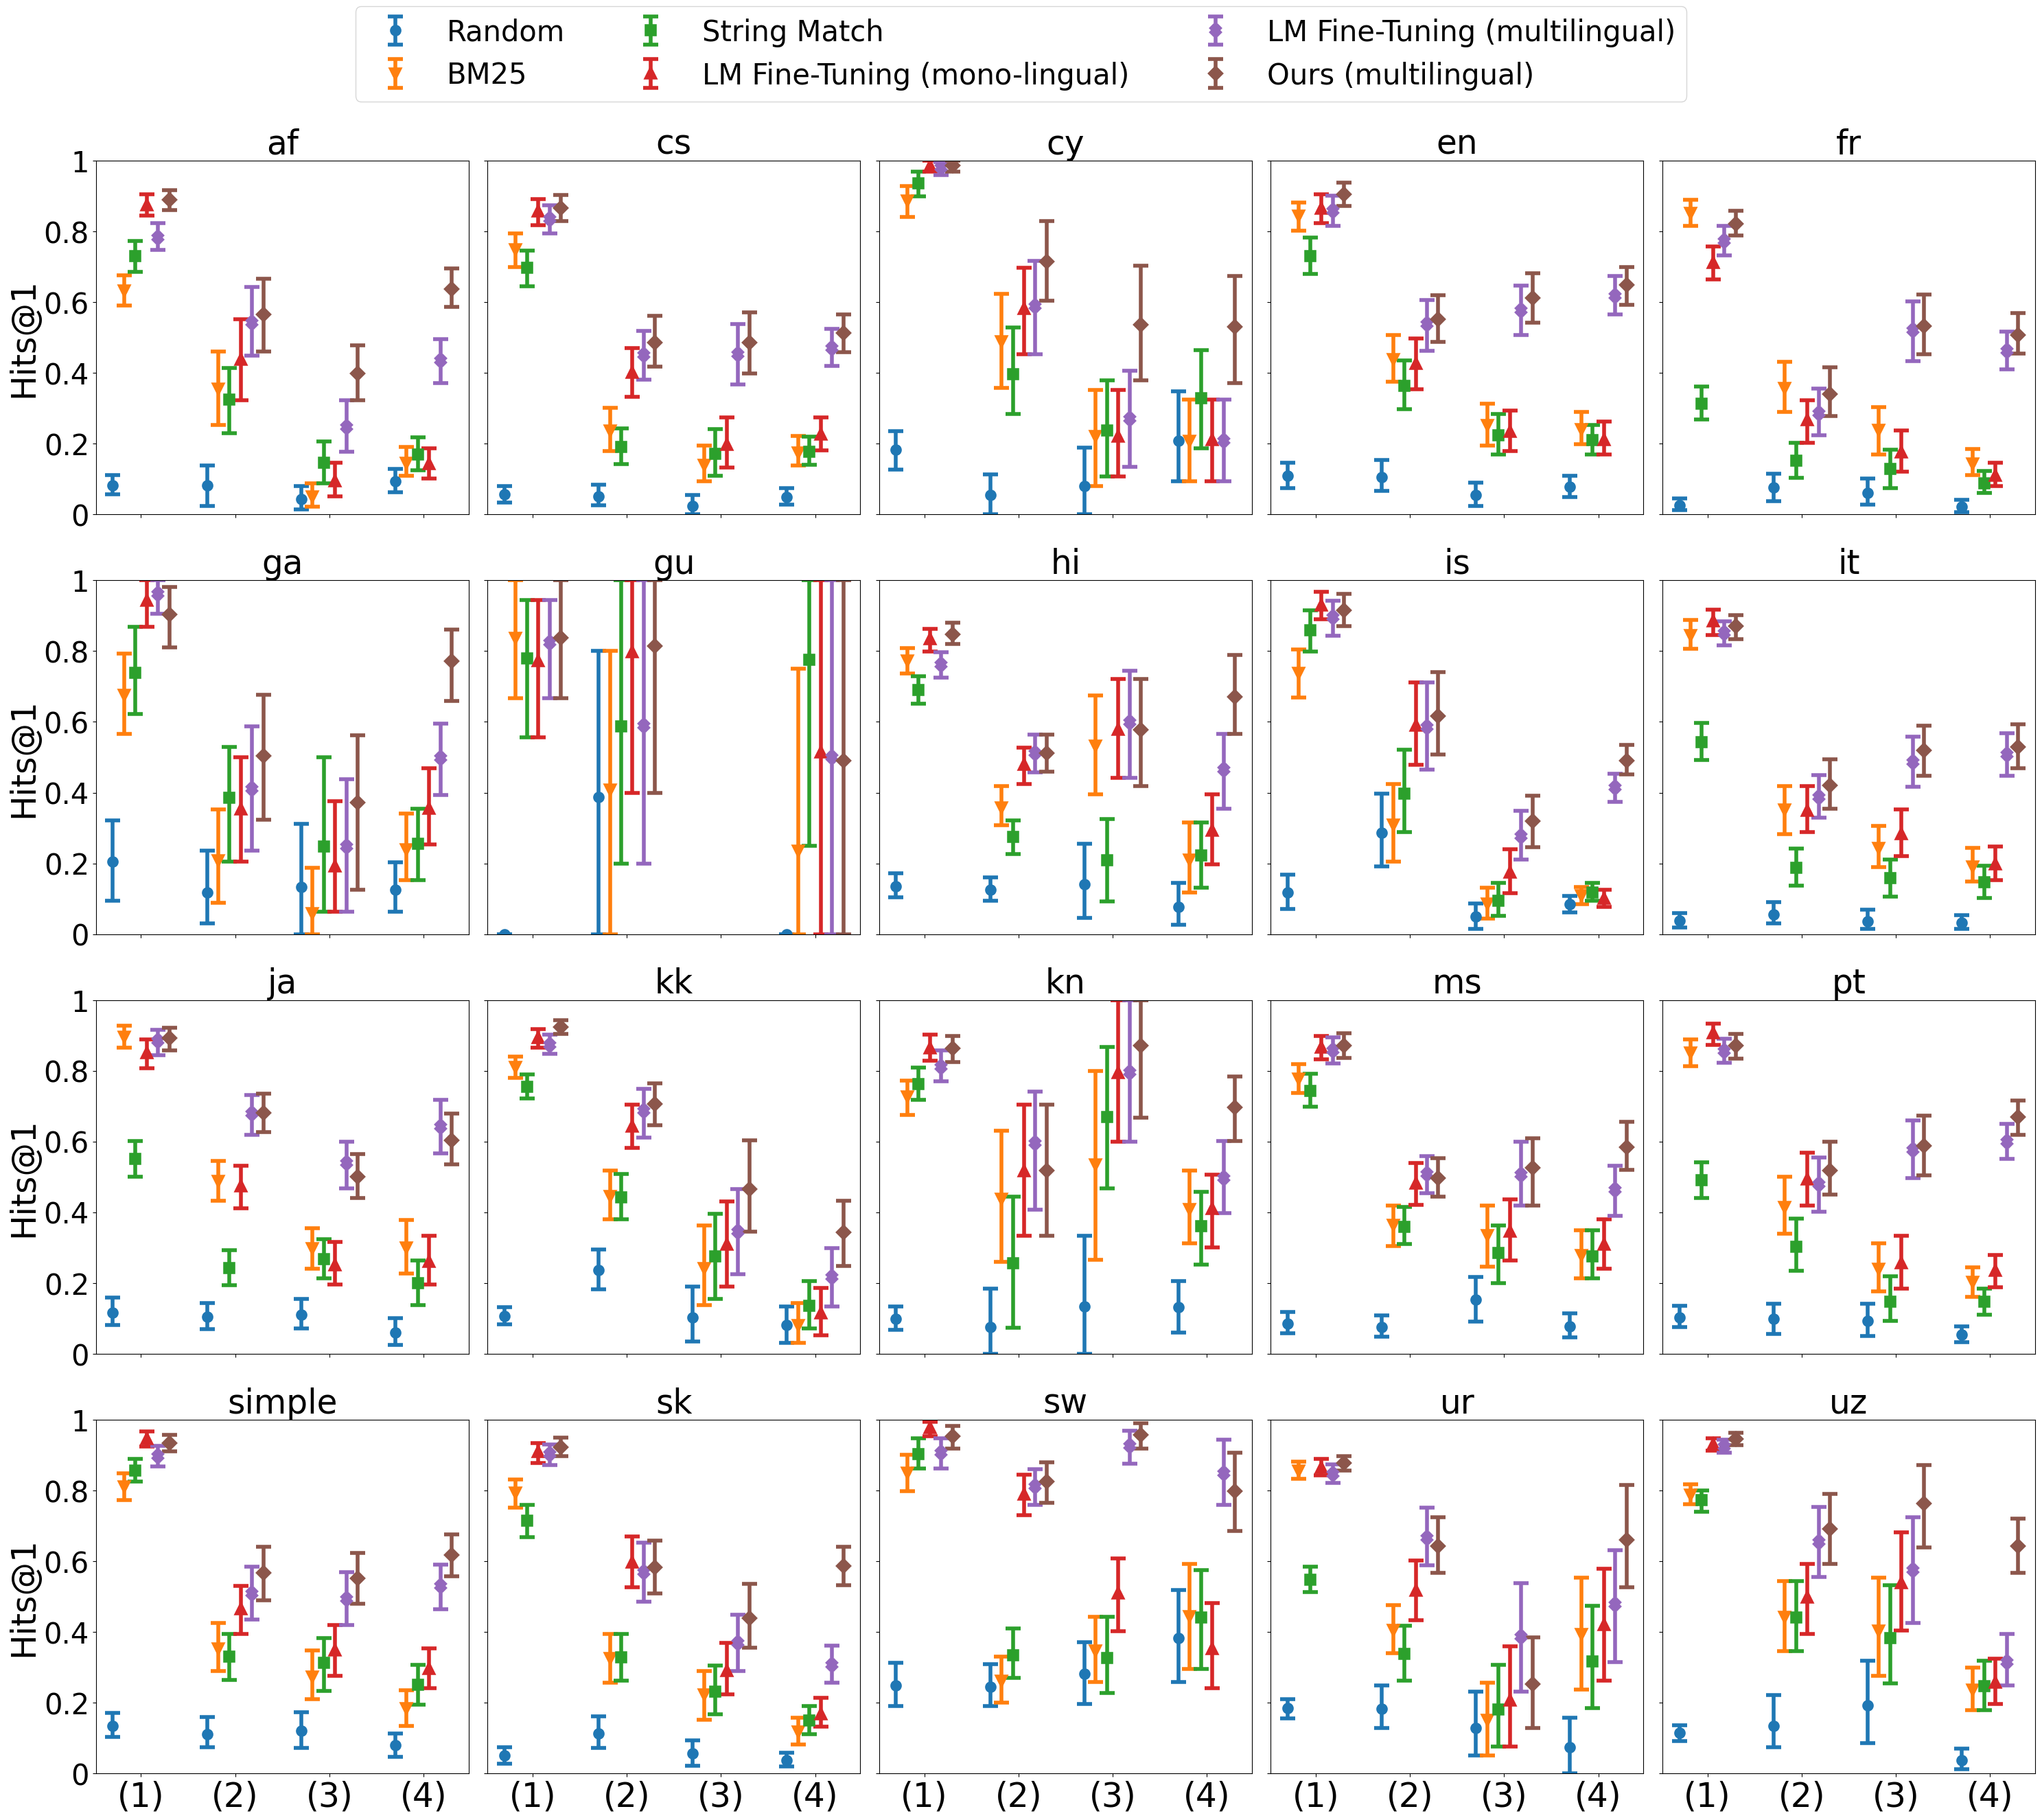

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(30, 25))

langs = sorted(list(dfs.keys()))
for i in range(4):
    for j in range(5):
        lang = langs[i * 5 + j]
        counter = -2.5
        for column, label, marker, colour in zip(columns, labels, markers, colours):
            if column in dfs[lang].columns:
                # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
                y_points = [stratified_hits_at_k[lang][column][s]['1']['score'] if s in stratified_hits_at_k[lang][column].keys() else -1 for s in strategies]
                y_err = [[stratified_hits_at_k[lang][column][s]['1']['score'] - stratified_hits_at_k[lang][column][s]['1']['cl'][0] if s in stratified_hits_at_k[lang][column].keys() else 0 for s in strategies], [stratified_hits_at_k[lang][column][s]['1']['cl'][1] - stratified_hits_at_k[lang][column][s]['1']['score'] if s in stratified_hits_at_k[lang][column].keys() else 0 for s in strategies]]
                axs[i, j].errorbar([s + counter * 0.12 for s in range(len(strategies))], y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, color=colour)
                # set y axis limits (0-1)
                axs[i, j].set_ylim(0, 1)
                # set the title of each subplot to the language
                axs[i, j].set_title(lang, fontsize=35)
                # remove the x labels
                axs[i, j].set_xticklabels([])
                axs[i, j].set_xticks([0, 1, 2, 3])
                # remove the y labels
                axs[i, j].set_yticklabels([])
                axs[i, j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                # rotate x labels
                counter += 1
        if f'roberta_simple_{lang}' in dfs[lang].columns:
            y_points = [stratified_hits_at_k[lang][f'roberta_simple_{lang}'][s]['1']['score'] if s in stratified_hits_at_k[lang][f'roberta_simple_{lang}'].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[lang][f'roberta_simple_{lang}'][s]['1']['score'] - stratified_hits_at_k[lang][f'roberta_simple_{lang}'][s]['1']['cl'][0] if s in stratified_hits_at_k[lang][f'roberta_simple_{lang}'].keys() else 0 for s in strategies], [stratified_hits_at_k[lang][f'roberta_simple_{lang}'][s]['1']['cl'][1] - stratified_hits_at_k[lang][f'roberta_simple_{lang}'][s]['1']['score'] if s in stratified_hits_at_k[lang][f'roberta_simple_{lang}'].keys() else 0 for s in strategies]]
            axs[i, j].errorbar([s + counter * 0.12 for s in range(len(strategies))], y_points, yerr=y_err, marker='^', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='$m_{\\text{SIMPLE}}$', color='C3')
            counter += 1
        if f'roberta_full_{lang}' in dfs[lang].columns:
            y_points = [stratified_hits_at_k[lang][f'roberta_full_{lang}'][s]['1']['score'] if s in stratified_hits_at_k[lang][f'roberta_full_{lang}'].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[lang][f'roberta_full_{lang}'][s]['1']['score'] - stratified_hits_at_k[lang][f'roberta_full_{lang}'][s]['1']['cl'][0] if s in stratified_hits_at_k[lang][f'roberta_full_{lang}'].keys() else 0 for s in strategies], [stratified_hits_at_k[lang][f'roberta_full_{lang}'][s]['1']['cl'][1] - stratified_hits_at_k[lang][f'roberta_full_{lang}'][s]['1']['score'] if s in stratified_hits_at_k[lang][f'roberta_full_{lang}'].keys() else 0 for s in strategies]]
            axs[i, j].errorbar([s + counter * 0.12 for s in range(len(strategies))], y_points, yerr=y_err, marker='X', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='$m_{\\text{FULL}}$', color='C4')
            counter += 1
        if f'roberta_full_multilingual' in dfs[lang].columns:
            y_points = [stratified_hits_at_k[lang][f'roberta_full_multilingual'][s]['1']['score'] if s in stratified_hits_at_k[lang][f'roberta_full_multilingual'].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[lang][f'roberta_full_multilingual'][s]['1']['score'] - stratified_hits_at_k[lang][f'roberta_full_multilingual'][s]['1']['cl'][0] if s in stratified_hits_at_k[lang][f'roberta_full_multilingual'].keys() else 0 for s in strategies], [stratified_hits_at_k[lang][f'roberta_full_multilingual'][s]['1']['cl'][1] - stratified_hits_at_k[lang][f'roberta_full_multilingual'][s]['1']['score'] if s in stratified_hits_at_k[lang][f'roberta_full_multilingual'].keys() else 0 for s in strategies]]
            axs[i, j].errorbar([s + counter * 0.12 for s in range(len(strategies))], y_points, yerr=y_err, marker='D', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='$M_{\\text{FULL}}$', color='C5')
            counter += 1

# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles, labels = axs[-1, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=30, bbox_to_anchor=(0.5, 1.07))

for i in range(4):
    # set y axis labels
    axs[i, 0].set_ylabel('Hits@1', fontsize=35)
    # set y ticks
    axs[i, 0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    axs[i, 0].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=30)
    
for i in range(5):
    axs[-1, i].set_xticks([0, 1, 2, 3])
    axs[-1, i].set_xticklabels(['(1)', '(2)', '(3)', '(4)'], fontsize=35)
                
plt.tight_layout()

## Zero-Shot vs Fine-Tuned

In [34]:
columns = ['roberta_full_multilingual', 'roberta_full_multilingual_small']
labels = ['$M_{\\text{LARGE}}$ (Multilingual)', '$M_{\\text{SMALL}}$ (Zero-Shot)']
langs = sorted(['fr', 'pt', 'ms', 'sk', 'simple', 'kk', 'af', 'ga', 'gu'])
markers = ['o', 'v']
colours = ['C0', 'C1']
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']

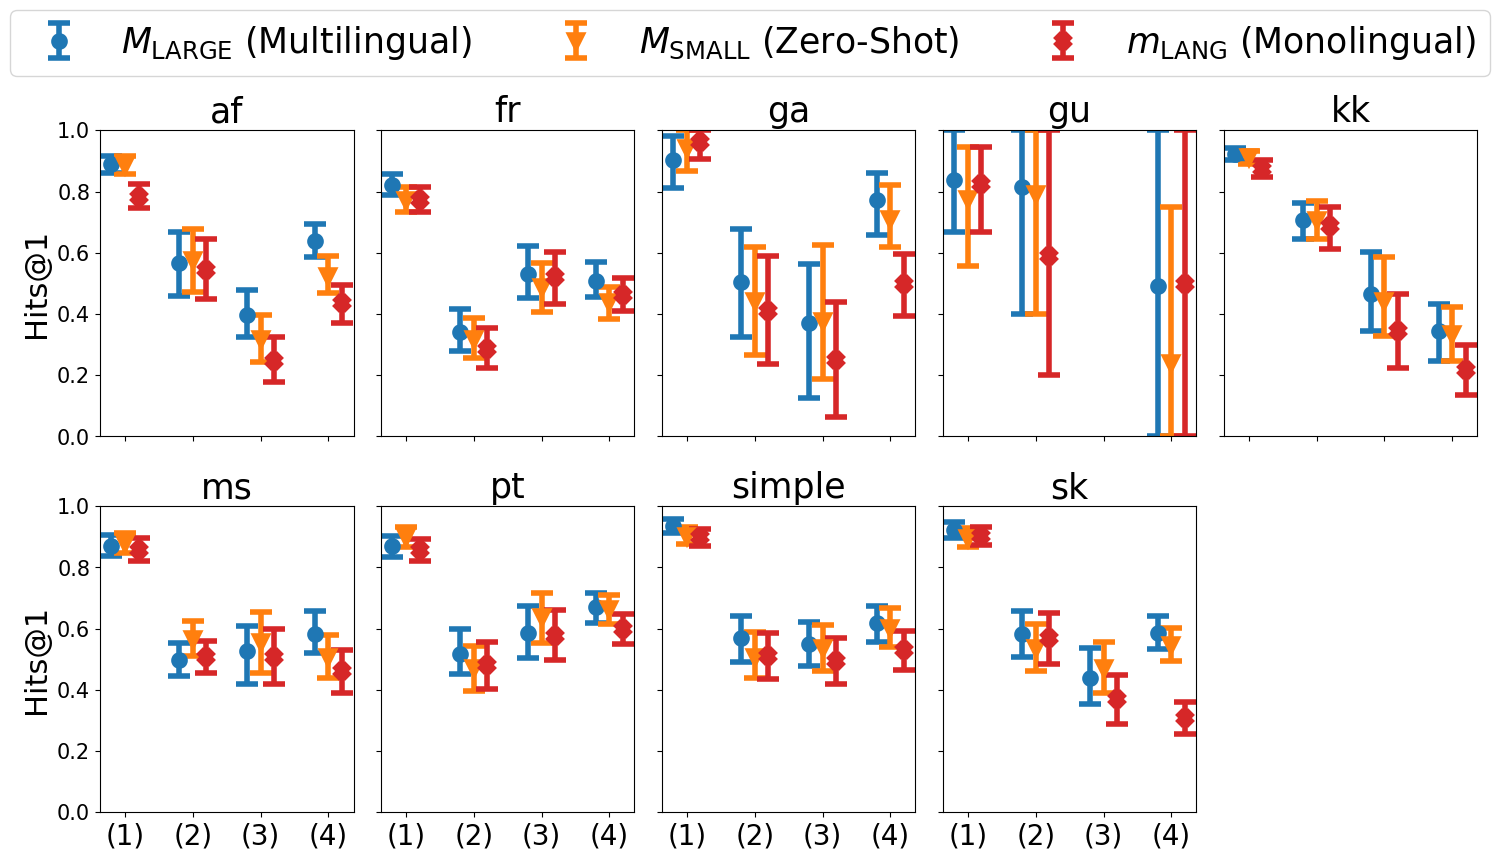

In [35]:
fig, axs = plt.subplots(2, 5, figsize=(15, 8))
# fig.suptitle('Hits@1', fontsize=20, y=1.02, fontweight='bold')

for i in range(2):
    for j in range(5):
        if i * 5 + j >= len(langs):
            break
        lang = langs[i * 5 + j]
        counter = -1
        for column, label, marker, colour in zip(columns, labels, markers, colours):
            if column in dfs[lang].columns:
                # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
                y_points = [stratified_hits_at_k[lang][column][s]['1']['score'] if s in stratified_hits_at_k[lang][column].keys() else -1 for s in strategies]
                y_err = [[stratified_hits_at_k[lang][column][s]['1']['score'] - stratified_hits_at_k[lang][column][s]['1']['cl'][0] if s in stratified_hits_at_k[lang][column].keys() else 0 for s in strategies], [stratified_hits_at_k[lang][column][s]['1']['cl'][1] - stratified_hits_at_k[lang][column][s]['1']['score'] if s in stratified_hits_at_k[lang][column].keys() else 0 for s in strategies]]
                axs[i, j].errorbar([0 + counter * 0.2, 1 + counter * 0.2, 2 + counter * 0.2, 3 + counter * 0.2], y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, color=colour)
                # set y axis limits (0-1)
                axs[i, j].set_ylim(0, 1)
                # set the title of each subplot to the language
                axs[i, j].set_title(lang, fontsize=25)
                # remove the x labels except for the bottom row
                axs[i, j].set_xticklabels([])
                axs[i, j].set_xticks([0, 1, 2, 3])
                # remove the y labels except for the left column
                if j != 0:
                    axs[i, j].set_yticklabels([])
                else:
                    # set y title to Hits@1
                    axs[i, j].set_ylabel('Hits@1', fontsize=22)
                # rotate x labels
                # axs[i, j].tick_params(axis='x', rotation=30)
                counter += 1
        extra_column = 'roberta_full_' + lang
        y_points = [stratified_hits_at_k[lang][extra_column][s]['1']['score'] if s in stratified_hits_at_k[lang][extra_column].keys() else -1 for s in strategies]
        y_err = [[stratified_hits_at_k[lang][extra_column][s]['1']['score'] - stratified_hits_at_k[lang][extra_column][s]['1']['cl'][0] if s in stratified_hits_at_k[lang][extra_column].keys() else 0 for s in strategies], [stratified_hits_at_k[lang][extra_column][s]['1']['cl'][1] - stratified_hits_at_k[lang][extra_column][s]['1']['score'] if s in stratified_hits_at_k[lang][extra_column].keys() else 0 for s in strategies]]
        axs[i, j].errorbar([0 + counter * 0.2, 1 + counter * 0.2, 2 + counter * 0.2, 3 + counter * 0.2], y_points, yerr=y_err, marker='X', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='$m_{\\text{LANG}}$ (Monolingual)', color='C3')

# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles_, labels_ = axs[0, 0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', ncol=6, fontsize=25, bbox_to_anchor=(0.5, 1.1))

# set the x ticks in the last row to be the strategies
for j in range(5):
    axs[-1, j].set_xticks([0, 1, 2, 3])
    axs[-1, j].set_xticklabels(['(1)', '(2)', '(3)', '(4)'], fontsize=20)
    
# remove the plot from position (-1, -1)
fig.delaxes(axs[-1, -1])

plt.tight_layout()

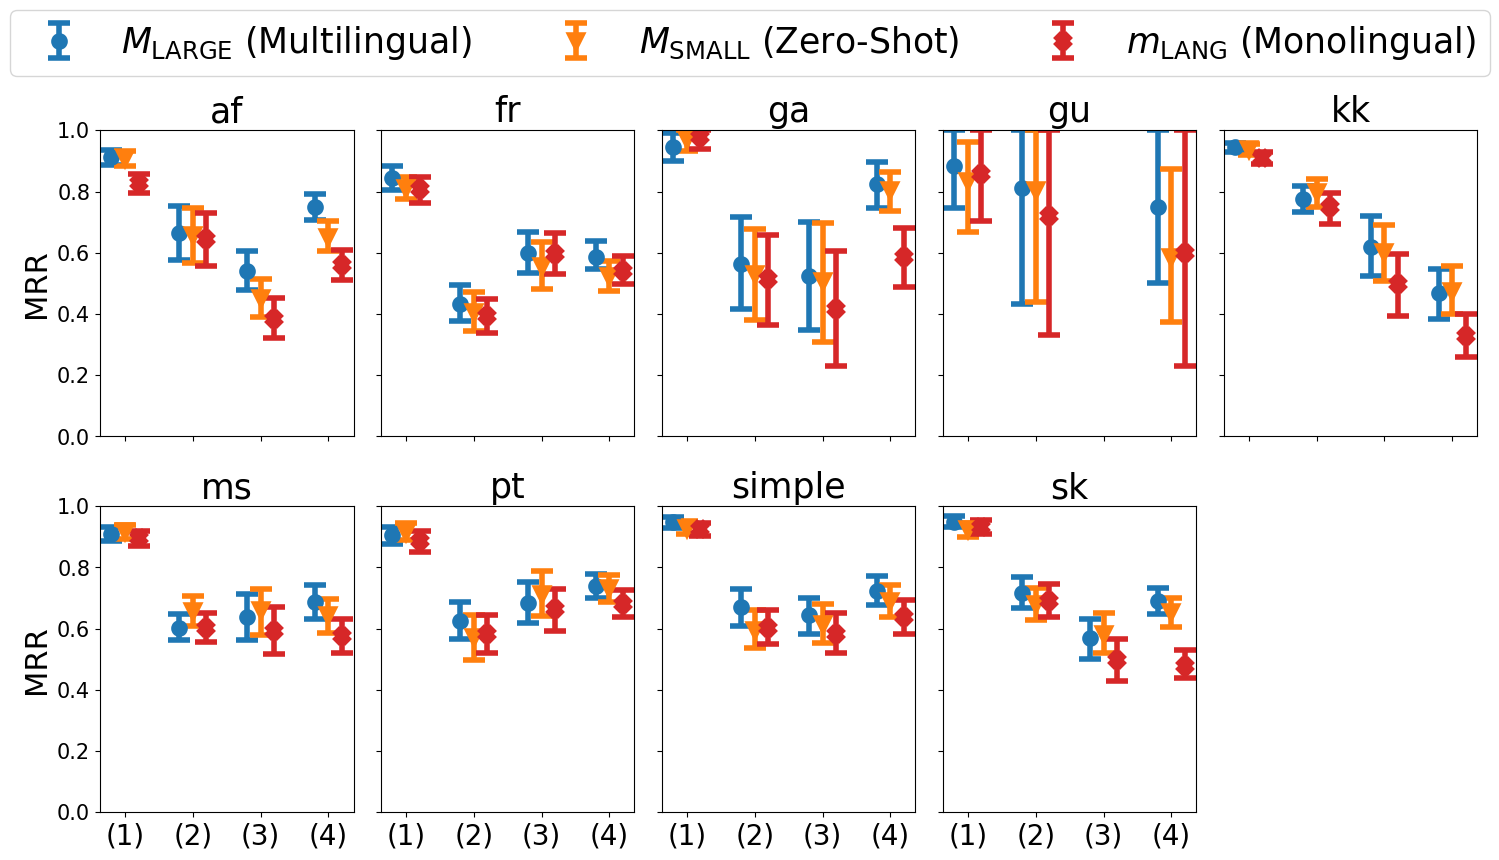

In [36]:
fig, axs = plt.subplots(2, 5, figsize=(15, 8))
# fig.suptitle('Hits@1', fontsize=20, y=1.02, fontweight='bold')

for i in range(2):
    for j in range(5):
        if i * 5 + j >= len(langs):
            break
        lang = langs[i * 5 + j]
        counter = -1
        for column, label, marker, colour in zip(columns, labels, markers, colours):
            if column in dfs[lang].columns:
                # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
                y_points = [stratified_mrr_at_k[lang][column][s]['max']['score'] if s in stratified_mrr_at_k[lang][column].keys() else -1 for s in strategies]
                y_err = [[stratified_mrr_at_k[lang][column][s]['max']['score'] - stratified_mrr_at_k[lang][column][s]['max']['cl'][0] if s in stratified_mrr_at_k[lang][column].keys() else 0 for s in strategies], [stratified_mrr_at_k[lang][column][s]['max']['cl'][1] - stratified_mrr_at_k[lang][column][s]['max']['score'] if s in stratified_mrr_at_k[lang][column].keys() else 0 for s in strategies]]
                axs[i, j].errorbar([0 + counter * 0.2, 1 + counter * 0.2, 2 + counter * 0.2, 3 + counter * 0.2], y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, color=colour)
                # set y axis limits (0-1)
                axs[i, j].set_ylim(0, 1)
                # set the title of each subplot to the language
                axs[i, j].set_title(lang, fontsize=25)
                # remove the x labels except for the bottom row
                axs[i, j].set_xticklabels([])
                axs[i, j].set_xticks([0, 1, 2, 3])
                # remove the y labels except for the left column
                if j != 0:
                    axs[i, j].set_yticklabels([])
                else:
                    # set y title to Hits@1
                    axs[i, j].set_ylabel('MRR', fontsize=22)
                # rotate x labels
                # axs[i, j].tick_params(axis='x', rotation=30)
                counter += 1
        extra_column = 'roberta_full_' + lang
        y_points = [stratified_mrr_at_k[lang][extra_column][s]['max']['score'] if s in stratified_mrr_at_k[lang][extra_column].keys() else -1 for s in strategies]
        y_err = [[stratified_mrr_at_k[lang][extra_column][s]['max']['score'] - stratified_mrr_at_k[lang][extra_column][s]['max']['cl'][0] if s in stratified_mrr_at_k[lang][extra_column].keys() else 0 for s in strategies], [stratified_mrr_at_k[lang][extra_column][s]['max']['cl'][1] - stratified_mrr_at_k[lang][extra_column][s]['max']['score'] if s in stratified_mrr_at_k[lang][extra_column].keys() else 0 for s in strategies]]
        axs[i, j].errorbar([0 + counter * 0.2, 1 + counter * 0.2, 2 + counter * 0.2, 3 + counter * 0.2], y_points, yerr=y_err, marker='X', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='$m_{\\text{LANG}}$ (Monolingual)', color='C3')

# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles_, labels_ = axs[0, 0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', ncol=6, fontsize=25, bbox_to_anchor=(0.5, 1.1))

# set the x ticks in the last row to be the strategies
for j in range(5):
    axs[-1, j].set_xticks([0, 1, 2, 3])
    axs[-1, j].set_xticklabels(['(1)', '(2)', '(3)', '(4)'], fontsize=20)
    
# remove the plot from position (-1, -1)
fig.delaxes(axs[-1, -1])

plt.tight_layout()

# Plot Ablations

## Impact of each modification to training

In [57]:
langs = ['kn', 'uz', 'cs', 'en']
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
columns = ['roberta_simple_rank', 'roberta_mask_rank', 'roberta_section_rank', 'roberta_mention_rank', 'roberta_two_stage_rank']
labels = ['(1): LM Fine-Tuning', '(2): (1) + Data Augmentation', '(3): (2) + Section Knowledge', '(4): (3) + Mention Knowledge', '(5): (4) + Second Stage']
markers = ['o', 'v', 's', 'D', 'X']
colours = ['C0', 'C1', 'C2', 'C3', 'C4']

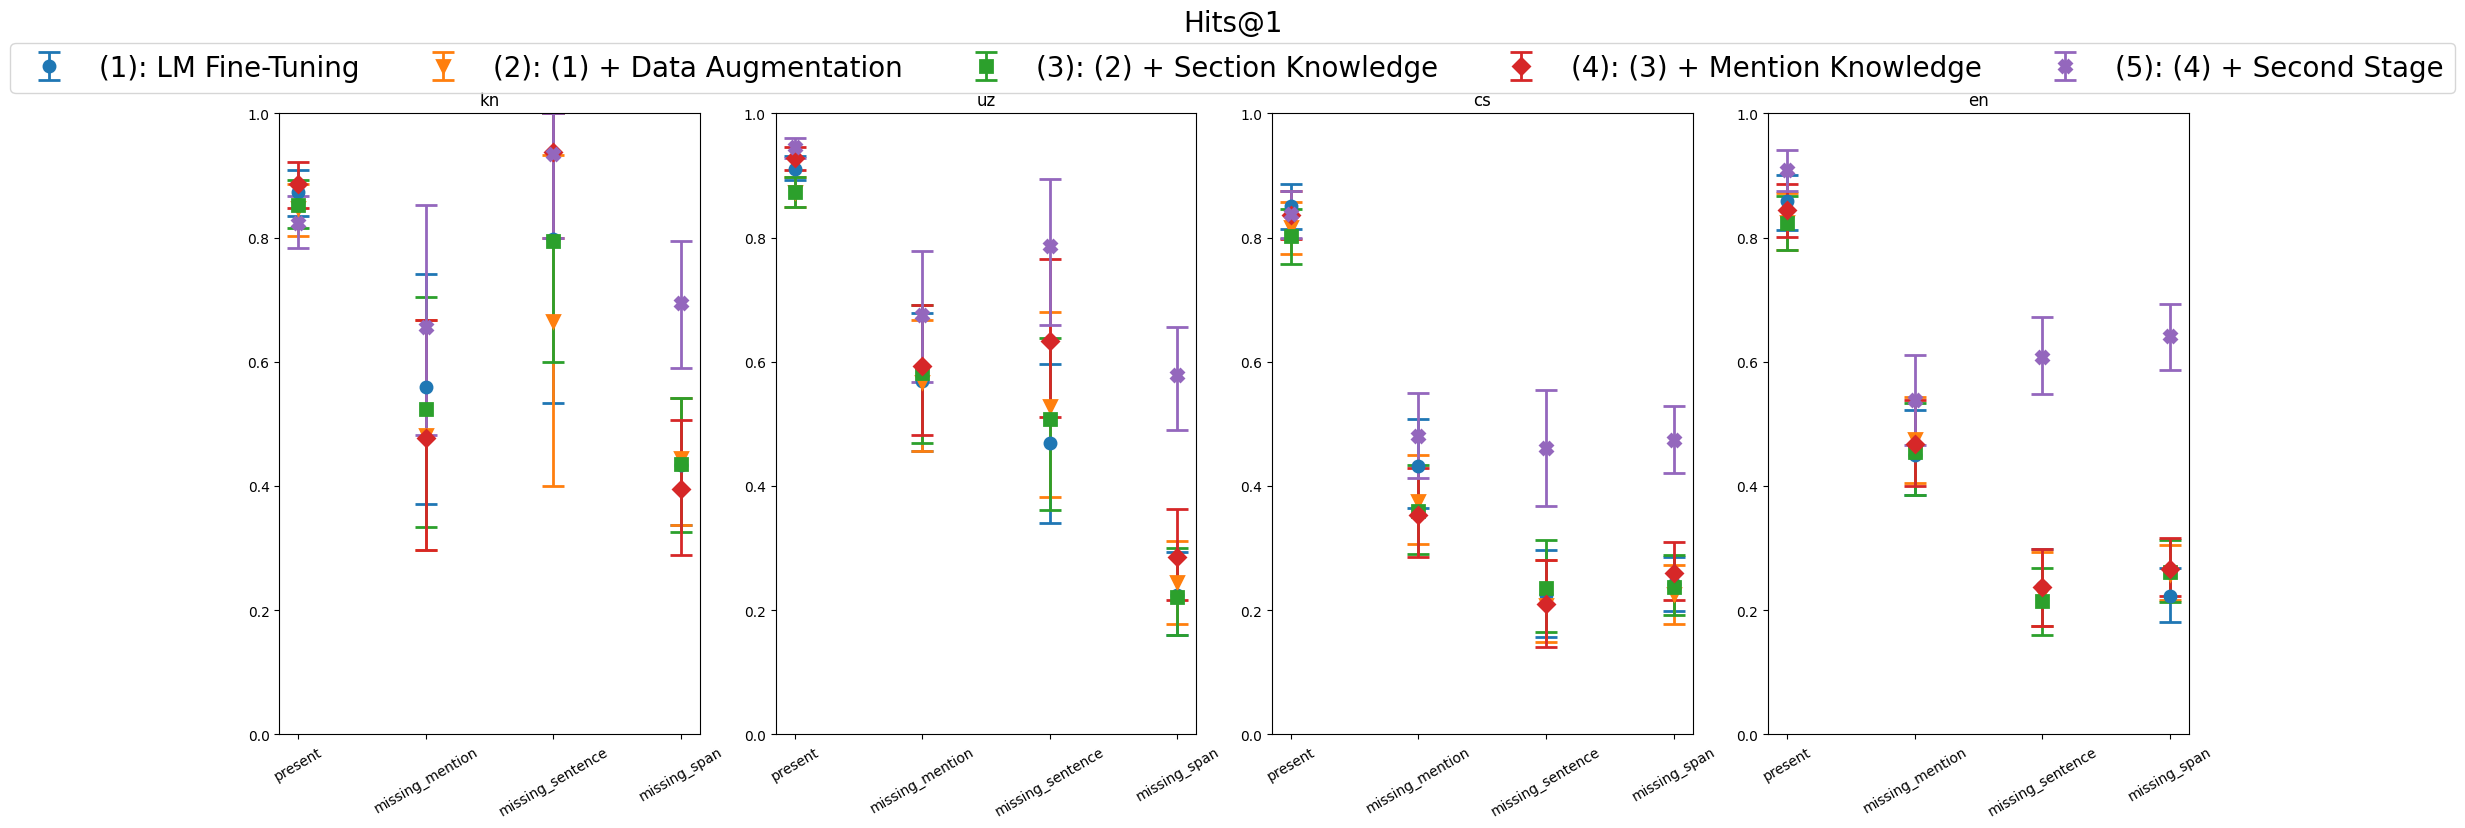

In [58]:
fig, axs = plt.subplots(1, 4, figsize=(20, 8))
fig.suptitle('Hits@1', fontsize=20, y=1.03)

for i, ax in enumerate(axs):
    for column, label, marker, colour in zip(columns, labels, markers, colours):
        column = column + '_multilingual'
        if column in dfs[langs[i]].columns:
            # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
            y_points = [stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[langs[i]][column][s]['1']['score'] - stratified_hits_at_k[langs[i]][column][s]['1']['cl'][0] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies], [stratified_hits_at_k[langs[i]][column][s]['1']['cl'][1] - stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies]]
            ax.errorbar(strategies, y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=2, markeredgewidth=2, color=colour)
            # set y axis limits (0-1)
            ax.set_ylim(0, 1)
            # set the title of each subplot to the language
            ax.set_title(langs[i])
            # rotate x labels
            ax.tick_params(axis='x', rotation=30)
            
# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles_, labels_ = axs[0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 1.005))

plt.tight_layout()

In [63]:
for lang in langs:
    print("\\multirow{5}{*}{" + lang + "} &", end='')
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    for i, column in enumerate(columns):
        column = column + '_multilingual'
        if i != 0:
            print('\n &', end='')
        print(f" ({i + 1})", end='')
        for strategy in strategies:
            print(f" & {stratified_hits_at_k[lang][column][strategy]['1']['score']:.3f} & {stratified_mrr_at_k[lang][column][strategy]['max']['score']:.3f}", end='')
            # print score and confidence interval for each strategy for each column
            # print(f"{column} {strategy} {lang} MRR@max: {stratified_mrr_at_k[lang][column][strategy]['max']['score']} {stratified_mrr_at_k[lang][column][strategy]['max']['cl']}")
            # print(f"{column} {strategy} {lang} Hits@1: {stratified_hits_at_k[lang][column][strategy]['1']['score']} {stratified_hits_at_k[lang][column][strategy]['1']['cl']}")
        average_hits_at_k_missing = compute_hits(missing_df[column].tolist())
        average_mrr_at_k_missing = compute_mrr(missing_df[column].tolist())
        print(f" & {average_hits_at_k_missing['1']['score']:.3f} & {average_mrr_at_k_missing['max']['score']:.3f}", end='')
        print(' \\\\', end='')
    print('\\hline')


\multirow{5}{*}{kn} & (1) & 0.874 & 0.892 & 0.560 & 0.641 & 0.798 & 0.839 & 0.434 & 0.566 & 0.505 & 0.618 \\
 & (2) & 0.848 & 0.866 & 0.482 & 0.639 & 0.665 & 0.763 & 0.445 & 0.594 & 0.479 & 0.624 \\
 & (3) & 0.852 & 0.874 & 0.524 & 0.660 & 0.795 & 0.850 & 0.435 & 0.576 & 0.493 & 0.625 \\
 & (4) & 0.886 & 0.901 & 0.477 & 0.625 & 0.938 & 0.941 & 0.395 & 0.536 & 0.481 & 0.604 \\
 & (5) & 0.824 & 0.860 & 0.656 & 0.750 & 0.935 & 0.957 & 0.694 & 0.839 & 0.716 & 0.835 \\\hline
\multirow{5}{*}{uz} & (1) & 0.911 & 0.933 & 0.569 & 0.670 & 0.469 & 0.561 & 0.224 & 0.333 & 0.364 & 0.467 \\
 & (2) & 0.874 & 0.908 & 0.568 & 0.653 & 0.529 & 0.628 & 0.245 & 0.366 & 0.387 & 0.492 \\
 & (3) & 0.873 & 0.902 & 0.582 & 0.667 & 0.507 & 0.609 & 0.221 & 0.329 & 0.371 & 0.470 \\
 & (4) & 0.928 & 0.943 & 0.593 & 0.681 & 0.634 & 0.708 & 0.286 & 0.381 & 0.431 & 0.522 \\
 & (5) & 0.945 & 0.957 & 0.676 & 0.748 & 0.787 & 0.842 & 0.578 & 0.714 & 0.641 & 0.746 \\\hline
\multirow{5}{*}{cs} & (1) & 0.851 & 0.879 & 0.432 

In [66]:
from scipy.stats import ttest_ind
for lang in langs:
    print(lang)
    test_df = dfs[lang]
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    # compute pair-wise p-values for each strategy
    for i, column_1 in enumerate(columns):
        column_1 += '_multilingual'
        for column_2 in columns[i+1:i+2]:
            column_2 += '_multilingual'
            for strategy in strategies:
                ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
                ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
                
                hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
                hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
                
                mrr_1 = [1 / rank for rank in ranks_1]
                mrr_2 = [1 / rank for rank in ranks_2]
                
                # compute the p-values
                print(f"{column_1} vs {column_2} for {strategy}")
                print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
                print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
                
            ranks_1_missing = missing_df[column_1].tolist()
            ranks_2_missing = missing_df[column_2].tolist()
            
            hits_at_1_1_missing = [1 if rank <= 1 else 0 for rank in ranks_1_missing]
            hits_at_1_2_missing = [1 if rank <= 1 else 0 for rank in ranks_2_missing]
            
            mrr_1_missing = [1 / rank for rank in ranks_1_missing]
            mrr_2_missing = [1 / rank for rank in ranks_2_missing]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for missing")
            print(f"\tMRR@max: {ttest_ind(mrr_1_missing, mrr_2_missing, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1_missing, hits_at_1_2_missing, alternative='less')}")

kn
roberta_simple_rank_multilingual vs roberta_mask_rank_multilingual for present
	MRR@max: TtestResult(statistic=1.047348223419686, pvalue=0.8523244456475865, df=614.0)
	Hits@1: TtestResult(statistic=0.9291634721012966, pvalue=0.8234152440268059, df=614.0)
roberta_simple_rank_multilingual vs roberta_mask_rank_multilingual for missing_mention
	MRR@max: TtestResult(statistic=0.04119055083177903, pvalue=0.5163491314418766, df=52.0)
	Hits@1: TtestResult(statistic=0.5359970314092778, pvalue=0.7028769686685152, df=52.0)
roberta_simple_rank_multilingual vs roberta_mask_rank_multilingual for missing_sentence
	MRR@max: TtestResult(statistic=0.5706759373449662, pvalue=0.71361440459033, df=28.0)
	Hits@1: TtestResult(statistic=0.8069465847859294, pvalue=0.7867505253053365, df=28.0)
roberta_simple_rank_multilingual vs roberta_mask_rank_multilingual for missing_span
	MRR@max: TtestResult(statistic=-0.44349032052079523, pvalue=0.3289978185163336, df=164.0)
	Hits@1: TtestResult(statistic=-0.155435783

In [67]:
from scipy.stats import ttest_ind
for lang in langs:
    print(lang)
    test_df = dfs[lang]
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    # compute pair-wise p-values for each strategy
    column_1 = columns[0] + '_multilingual'
    for column_2 in columns[1:]:
        column_2 += '_multilingual'
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
        
        ranks_1_missing = missing_df[column_1].tolist()
        ranks_2_missing = missing_df[column_2].tolist()
        
        hits_at_1_1_missing = [1 if rank <= 1 else 0 for rank in ranks_1_missing]
        hits_at_1_2_missing = [1 if rank <= 1 else 0 for rank in ranks_2_missing]
        
        mrr_1_missing = [1 / rank for rank in ranks_1_missing]
        mrr_2_missing = [1 / rank for rank in ranks_2_missing]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for missing")
        print(f"\tMRR@max: {ttest_ind(mrr_1_missing, mrr_2_missing, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1_missing, hits_at_1_2_missing, alternative='less')}")
        

kn
roberta_simple_rank_multilingual vs roberta_mask_rank_multilingual for present
	MRR@max: TtestResult(statistic=1.047348223419686, pvalue=0.8523244456475865, df=614.0)
	Hits@1: TtestResult(statistic=0.9291634721012966, pvalue=0.8234152440268059, df=614.0)
roberta_simple_rank_multilingual vs roberta_mask_rank_multilingual for missing_mention
	MRR@max: TtestResult(statistic=0.04119055083177903, pvalue=0.5163491314418766, df=52.0)
	Hits@1: TtestResult(statistic=0.5359970314092778, pvalue=0.7028769686685152, df=52.0)
roberta_simple_rank_multilingual vs roberta_mask_rank_multilingual for missing_sentence
	MRR@max: TtestResult(statistic=0.5706759373449662, pvalue=0.71361440459033, df=28.0)
	Hits@1: TtestResult(statistic=0.8069465847859294, pvalue=0.7867505253053365, df=28.0)
roberta_simple_rank_multilingual vs roberta_mask_rank_multilingual for missing_span
	MRR@max: TtestResult(statistic=-0.44349032052079523, pvalue=0.3289978185163336, df=164.0)
	Hits@1: TtestResult(statistic=-0.155435783

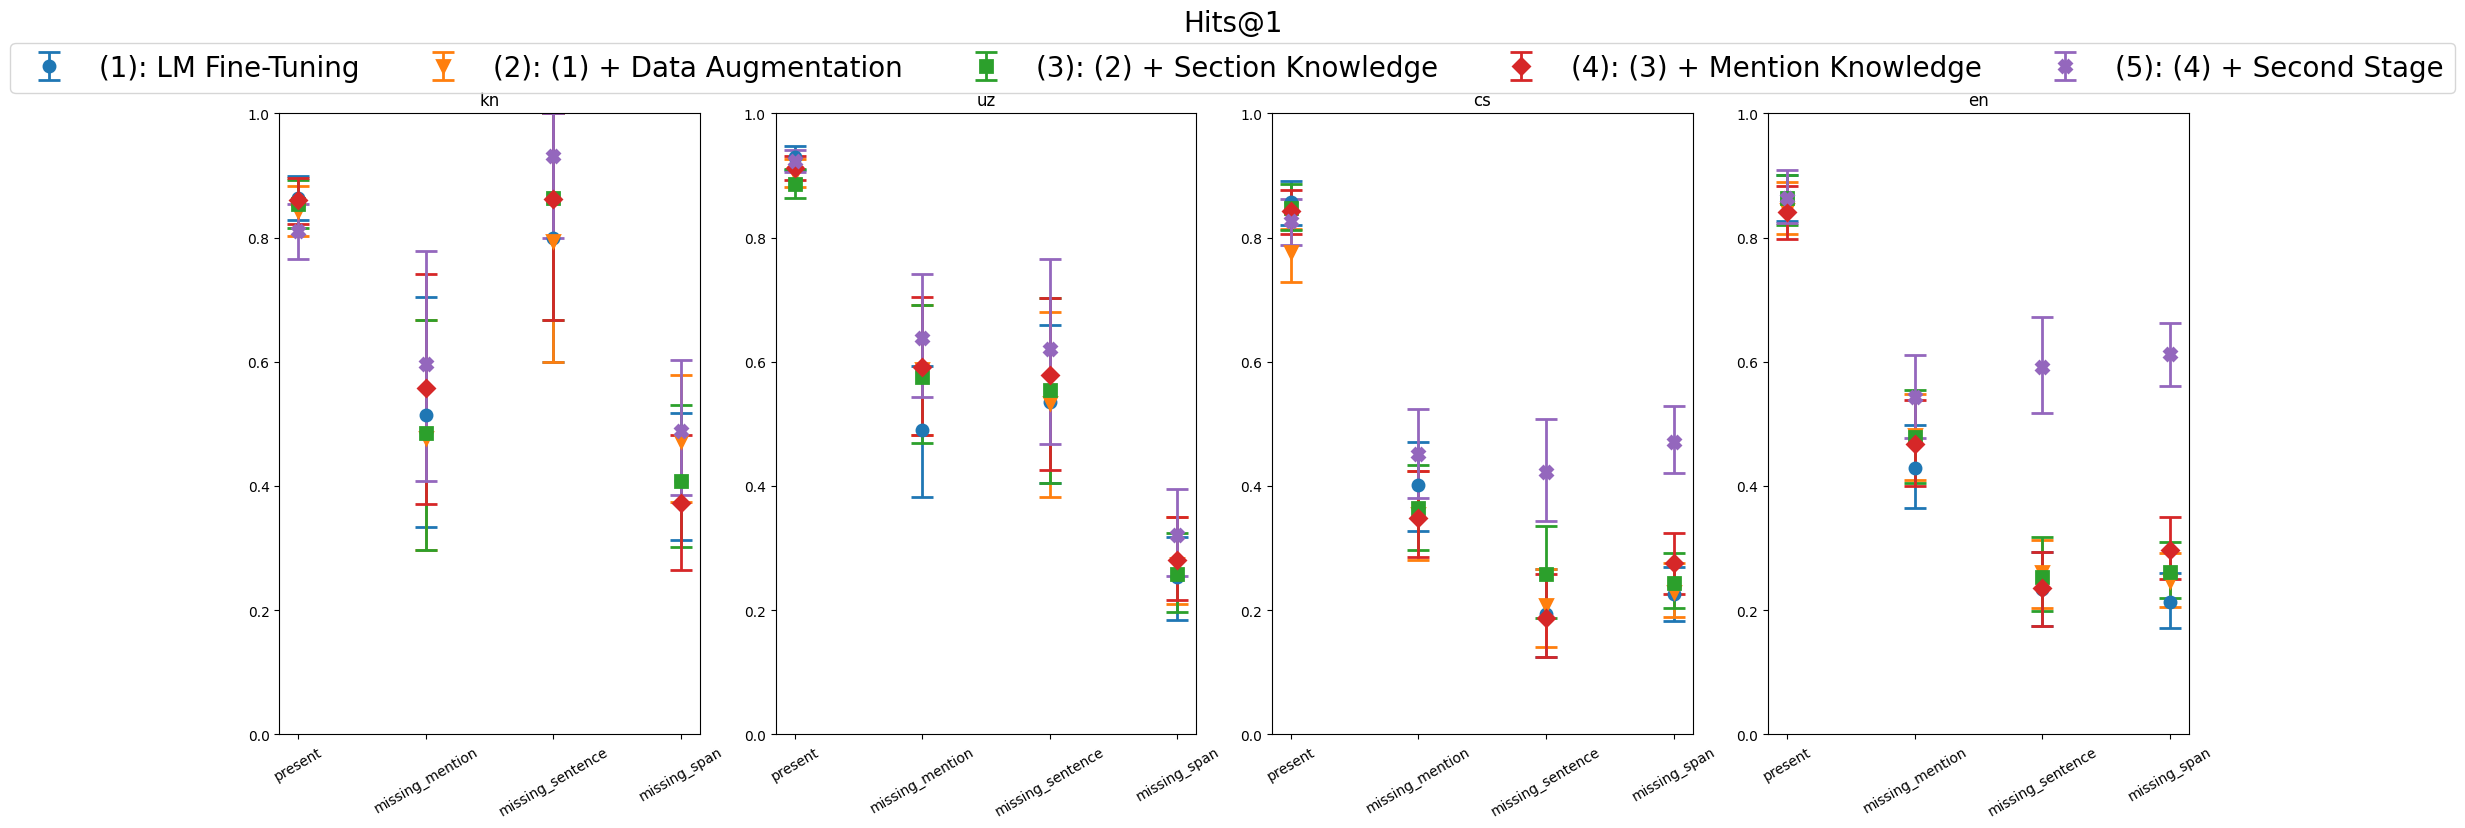

In [27]:
fig, axs = plt.subplots(1, 4, figsize=(20, 8))
fig.suptitle('Hits@1', fontsize=20, y=1.03)

for i, ax in enumerate(axs):
    for column, label, marker, colour in zip(columns, labels, markers, colours):
        column = column + '_' + langs[i]
        if column in dfs[langs[i]].columns:
            # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
            y_points = [stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[langs[i]][column][s]['1']['score'] - stratified_hits_at_k[langs[i]][column][s]['1']['cl'][0] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies], [stratified_hits_at_k[langs[i]][column][s]['1']['cl'][1] - stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies]]
            ax.errorbar(strategies, y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=2, markeredgewidth=2, color=colour)
            # set y axis limits (0-1)
            ax.set_ylim(0, 1)
            # set the title of each subplot to the language
            ax.set_title(langs[i])
            # rotate x labels
            ax.tick_params(axis='x', rotation=30)
            
# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles_, labels_ = axs[0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 1.005))

plt.tight_layout()

## Impact of each training stage

In [68]:
langs = ['kn', 'uz', 'cs', 'en']
columns = ['roberta_simple_rank', 'roberta_only_stage_two_rank', 'roberta_two_stage_no_corrupt_rank', 'roberta_two_stage_rank']
labels = ['Only Stage 1', 'Only Stage 2', 'Stage 1 (No Corrupt) + Stage 2', 'Stage 1 + Stage 2']
markers = ['o', 'v', 's', 'D']
colours = ['C0', 'C1', 'C2', 'C3']

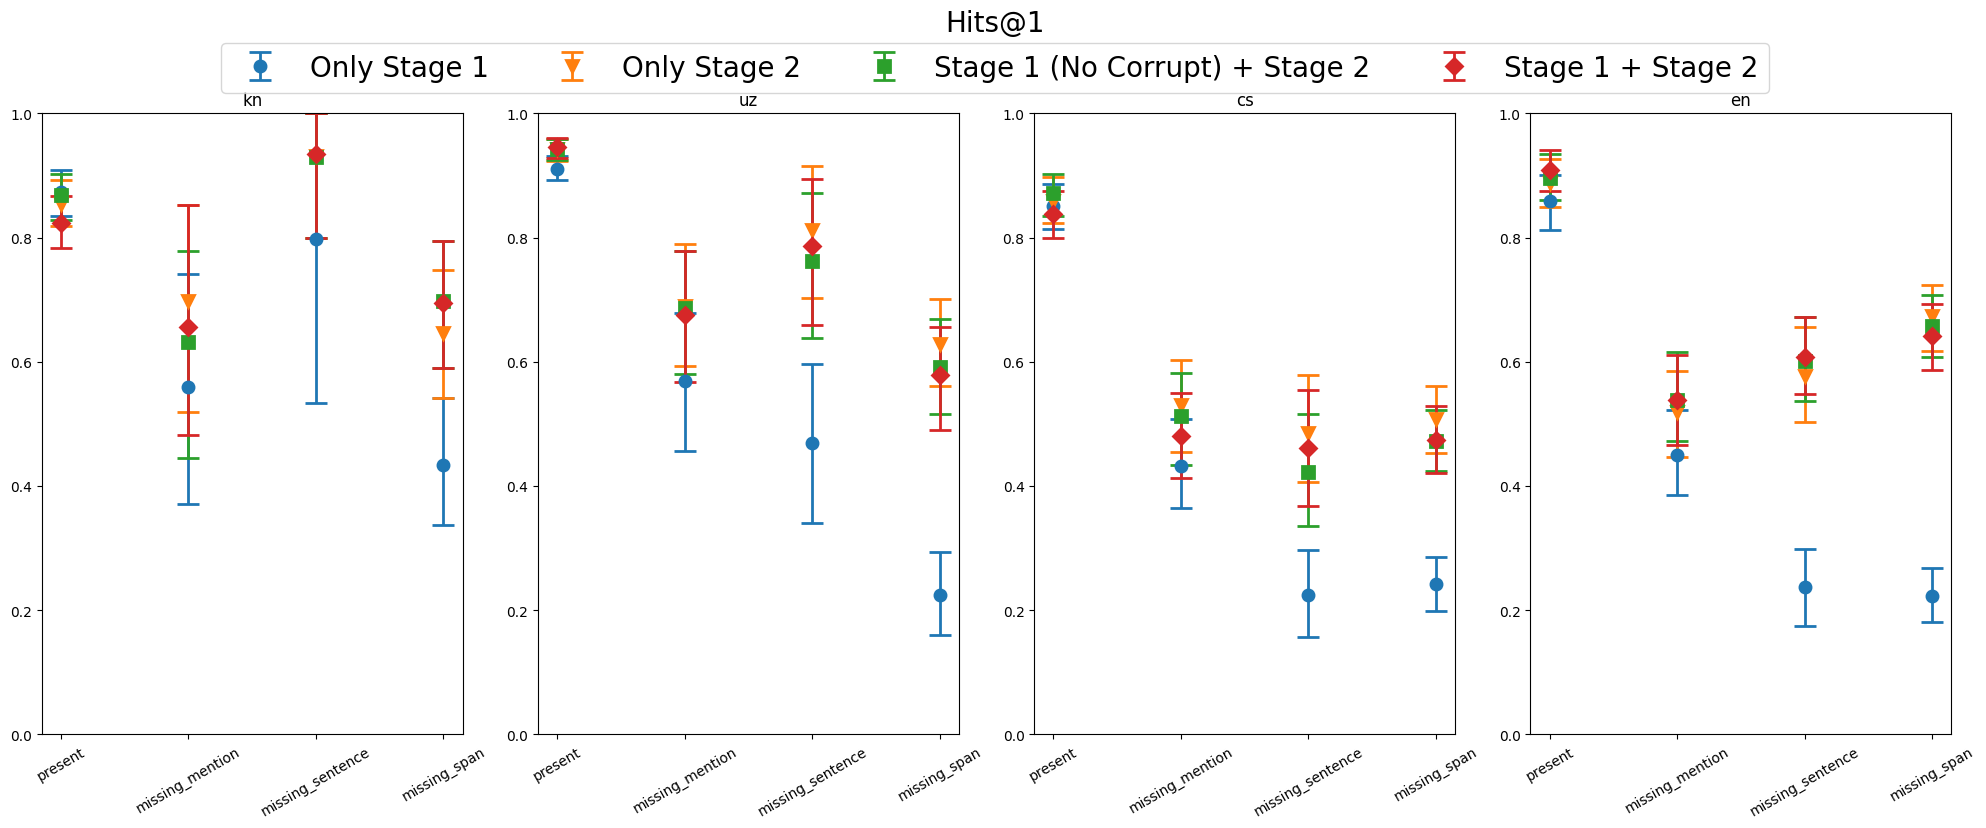

In [69]:
fig, axs = plt.subplots(1, 4, figsize=(20, 8))
fig.suptitle('Hits@1', fontsize=20, y=1.03)

for i, ax in enumerate(axs):
    for column, label, marker, colour in zip(columns, labels, markers, colours):
        column = column + '_' + 'multilingual'
        if column in dfs[langs[i]].columns:
            # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
            y_points = [stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[langs[i]][column][s]['1']['score'] - stratified_hits_at_k[langs[i]][column][s]['1']['cl'][0] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies], [stratified_hits_at_k[langs[i]][column][s]['1']['cl'][1] - stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies]]
            ax.errorbar(strategies, y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=2, markeredgewidth=2, color=colour)
            # set y axis limits (0-1)
            ax.set_ylim(0, 1)
            # set the title of each subplot to the language
            ax.set_title(langs[i])
            # rotate x labels
            ax.tick_params(axis='x', rotation=30)
            
# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles_, labels_ = axs[0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 1.005))

plt.tight_layout()

In [70]:
for lang in langs:
    print("\\multirow{4}{*}{" + lang + "} &", end='')
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    for i, column in enumerate(columns):
        column = column + '_multilingual'
        if i != 0:
            print('\n &', end='')
        print(f" ({i + 1})", end='')
        for strategy in strategies:
            print(f" & {stratified_hits_at_k[lang][column][strategy]['1']['score']:.3f} & {stratified_mrr_at_k[lang][column][strategy]['max']['score']:.3f}", end='')
            # print score and confidence interval for each strategy for each column
            # print(f"{column} {strategy} {lang} MRR@max: {stratified_mrr_at_k[lang][column][strategy]['max']['score']} {stratified_mrr_at_k[lang][column][strategy]['max']['cl']}")
            # print(f"{column} {strategy} {lang} Hits@1: {stratified_hits_at_k[lang][column][strategy]['1']['score']} {stratified_hits_at_k[lang][column][strategy]['1']['cl']}")
        average_hits_at_k_missing = compute_hits(missing_df[column].tolist())
        average_mrr_at_k_missing = compute_mrr(missing_df[column].tolist())
        print(f" & {average_hits_at_k_missing['1']['score']:.3f} & {average_mrr_at_k_missing['max']['score']:.3f}", end='')
        print(' \\\\', end='')
    print('\\hline')

\multirow{4}{*}{kn} & (1) & 0.874 & 0.892 & 0.560 & 0.641 & 0.798 & 0.839 & 0.434 & 0.566 & 0.500 & 0.618 \\
 & (2) & 0.854 & 0.879 & 0.697 & 0.753 & 0.931 & 0.946 & 0.647 & 0.812 & 0.695 & 0.817 \\
 & (3) & 0.868 & 0.890 & 0.631 & 0.731 & 0.930 & 0.966 & 0.697 & 0.824 & 0.711 & 0.818 \\
 & (4) & 0.824 & 0.860 & 0.656 & 0.750 & 0.935 & 0.957 & 0.694 & 0.839 & 0.720 & 0.834 \\\hline
\multirow{4}{*}{uz} & (1) & 0.911 & 0.933 & 0.569 & 0.670 & 0.469 & 0.561 & 0.224 & 0.333 & 0.360 & 0.469 \\
 & (2) & 0.942 & 0.957 & 0.689 & 0.773 & 0.812 & 0.850 & 0.629 & 0.733 & 0.677 & 0.764 \\
 & (3) & 0.942 & 0.958 & 0.686 & 0.769 & 0.763 & 0.823 & 0.592 & 0.708 & 0.647 & 0.744 \\
 & (4) & 0.945 & 0.957 & 0.676 & 0.748 & 0.787 & 0.842 & 0.578 & 0.714 & 0.641 & 0.744 \\\hline
\multirow{4}{*}{cs} & (1) & 0.851 & 0.879 & 0.432 & 0.525 & 0.225 & 0.308 & 0.242 & 0.313 & 0.294 & 0.372 \\
 & (2) & 0.859 & 0.884 & 0.531 & 0.624 & 0.485 & 0.591 & 0.507 & 0.621 & 0.510 & 0.615 \\
 & (3) & 0.871 & 0.896 & 0.512 

In [72]:
from scipy.stats import ttest_ind
for lang in langs:
    print(lang)
    test_df = dfs[lang]
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    # compute pair-wise p-values for each strategy
    column_1 = columns[0] + '_multilingual'
    for column_2 in columns[1:]:
        column_2 += '_multilingual'
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
        
        ranks_1_missing = missing_df[column_1].tolist()
        ranks_2_missing = missing_df[column_2].tolist()
        
        hits_at_1_1_missing = [1 if rank <= 1 else 0 for rank in ranks_1_missing]
        hits_at_1_2_missing = [1 if rank <= 1 else 0 for rank in ranks_2_missing]
        
        mrr_1_missing = [1 / rank for rank in ranks_1_missing]
        mrr_2_missing = [1 / rank for rank in ranks_2_missing]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for missing")
        print(f"\tMRR@max: {ttest_ind(mrr_1_missing, mrr_2_missing, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1_missing, hits_at_1_2_missing, alternative='less')}")

kn
roberta_simple_rank_multilingual vs roberta_only_stage_two_rank_multilingual for present
	MRR@max: TtestResult(statistic=0.5273331572790005, pvalue=0.7009236318191043, df=614.0)
	Hits@1: TtestResult(statistic=0.7035824175040944, pvalue=0.7590202104629835, df=614.0)
roberta_simple_rank_multilingual vs roberta_only_stage_two_rank_multilingual for missing_mention
	MRR@max: TtestResult(statistic=-1.0497482245123189, pvalue=0.1493441468042502, df=52.0)
	Hits@1: TtestResult(statistic=-1.1193802071650056, pvalue=0.13406099624231832, df=52.0)
roberta_simple_rank_multilingual vs roberta_only_stage_two_rank_multilingual for missing_sentence
	MRR@max: TtestResult(statistic=-1.056926480803706, pvalue=0.149789625659075, df=28.0)
	Hits@1: TtestResult(statistic=-1.0583005244258359, pvalue=0.1494817575272936, df=28.0)
roberta_simple_rank_multilingual vs roberta_only_stage_two_rank_multilingual for missing_span
	MRR@max: TtestResult(statistic=-4.656513360731732, pvalue=3.304205528671321e-06, df=164.

In [77]:
from scipy.stats import ttest_ind
for lang in langs:
    print(lang)
    test_df = dfs[lang]
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    # compute pair-wise p-values for each strategy
    column_1 = columns[1] + '_multilingual'
    for column_2 in [columns[0]] + columns[2:]:
        column_2 += '_multilingual'
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
        
        ranks_1_missing = missing_df[column_1].tolist()
        ranks_2_missing = missing_df[column_2].tolist()
        
        hits_at_1_1_missing = [1 if rank <= 1 else 0 for rank in ranks_1_missing]
        hits_at_1_2_missing = [1 if rank <= 1 else 0 for rank in ranks_2_missing]
        
        mrr_1_missing = [1 / rank for rank in ranks_1_missing]
        mrr_2_missing = [1 / rank for rank in ranks_2_missing]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for missing")
        print(f"\tMRR@max: {ttest_ind(mrr_1_missing, mrr_2_missing, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1_missing, hits_at_1_2_missing, alternative='less')}")

kn
roberta_only_stage_two_rank_multilingual vs roberta_simple_rank_multilingual for present
	MRR@max: TtestResult(statistic=-0.5273331572790005, pvalue=0.29907636818089567, df=614.0)
	Hits@1: TtestResult(statistic=-0.7035824175040944, pvalue=0.24097978953701654, df=614.0)
roberta_only_stage_two_rank_multilingual vs roberta_simple_rank_multilingual for missing_mention
	MRR@max: TtestResult(statistic=1.0497482245123189, pvalue=0.8506558531957498, df=52.0)
	Hits@1: TtestResult(statistic=1.1193802071650056, pvalue=0.8659390037576817, df=52.0)
roberta_only_stage_two_rank_multilingual vs roberta_simple_rank_multilingual for missing_sentence
	MRR@max: TtestResult(statistic=1.056926480803706, pvalue=0.8502103743409251, df=28.0)
	Hits@1: TtestResult(statistic=1.0583005244258359, pvalue=0.8505182424727065, df=28.0)
roberta_only_stage_two_rank_multilingual vs roberta_simple_rank_multilingual for missing_span
	MRR@max: TtestResult(statistic=4.656513360731732, pvalue=0.9999966957944714, df=164.0)
	

In [71]:
for lang in langs:
    print("\\multirow{4}{*}{" + lang + "} &", end='')
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    for i, column in enumerate(columns):
        column = column + '_' + lang
        if i != 0:
            print('\n &', end='')
        print(f" ({i + 1})", end='')
        for strategy in strategies:
            print(f" & {stratified_hits_at_k[lang][column][strategy]['1']['score']:.3f} & {stratified_mrr_at_k[lang][column][strategy]['max']['score']:.3f}", end='')
            # print score and confidence interval for each strategy for each column
            # print(f"{column} {strategy} {lang} MRR@max: {stratified_mrr_at_k[lang][column][strategy]['max']['score']} {stratified_mrr_at_k[lang][column][strategy]['max']['cl']}")
            # print(f"{column} {strategy} {lang} Hits@1: {stratified_hits_at_k[lang][column][strategy]['1']['score']} {stratified_hits_at_k[lang][column][strategy]['1']['cl']}")
        average_hits_at_k_missing = compute_hits(missing_df[column].tolist())
        average_mrr_at_k_missing = compute_mrr(missing_df[column].tolist())
        print(f" & {average_hits_at_k_missing['1']['score']:.3f} & {average_mrr_at_k_missing['max']['score']:.3f}", end='')
        print(' \\\\', end='')
    print('\\hline')


\multirow{4}{*}{kn} & (1) & 0.863 & 0.882 & 0.515 & 0.619 & 0.800 & 0.875 & 0.408 & 0.558 & 0.479 & 0.607 \\
 & (2) & 0.283 & 0.401 & 0.367 & 0.498 & 0.331 & 0.459 & 0.287 & 0.516 & 0.311 & 0.504 \\
 & (3) & 0.853 & 0.876 & 0.627 & 0.712 & 0.869 & 0.902 & 0.579 & 0.736 & 0.622 & 0.749 \\
 & (4) & 0.810 & 0.842 & 0.597 & 0.674 & 0.932 & 0.947 & 0.489 & 0.656 & 0.567 & 0.695 \\\hline
\multirow{4}{*}{uz} & (1) & 0.929 & 0.945 & 0.490 & 0.622 & 0.535 & 0.597 & 0.254 & 0.356 & 0.369 & 0.469 \\
 & (2) & 0.901 & 0.928 & 0.618 & 0.703 & 0.553 & 0.654 & 0.368 & 0.480 & 0.468 & 0.574 \\
 & (3) & 0.922 & 0.942 & 0.604 & 0.703 & 0.646 & 0.735 & 0.404 & 0.543 & 0.503 & 0.617 \\
 & (4) & 0.924 & 0.942 & 0.638 & 0.729 & 0.620 & 0.699 & 0.321 & 0.452 & 0.460 & 0.572 \\\hline
\multirow{4}{*}{cs} & (1) & 0.857 & 0.873 & 0.401 & 0.490 & 0.194 & 0.299 & 0.226 & 0.323 & 0.269 & 0.366 \\
 & (2) & 0.788 & 0.830 & 0.539 & 0.630 & 0.414 & 0.529 & 0.405 & 0.529 & 0.447 & 0.557 \\
 & (3) & 0.835 & 0.865 & 0.455 

In [79]:
from scipy.stats import ttest_ind
for lang in langs:
    print(lang)
    test_df = dfs[lang]
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    # compute pair-wise p-values for each strategy
    column_1 = columns[0] + '_' + lang
    for column_2 in columns[1:]:
        column_2 += '_' + lang
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
        
        ranks_1_missing = missing_df[column_1].tolist()
        ranks_2_missing = missing_df[column_2].tolist()
        
        hits_at_1_1_missing = [1 if rank <= 1 else 0 for rank in ranks_1_missing]
        hits_at_1_2_missing = [1 if rank <= 1 else 0 for rank in ranks_2_missing]
        
        mrr_1_missing = [1 / rank for rank in ranks_1_missing]
        mrr_2_missing = [1 / rank for rank in ranks_2_missing]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for missing")
        print(f"\tMRR@max: {ttest_ind(mrr_1_missing, mrr_2_missing, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1_missing, hits_at_1_2_missing, alternative='less')}")

kn
roberta_simple_rank_kn vs roberta_only_stage_two_rank_kn for present
	MRR@max: TtestResult(statistic=16.953832977961156, pvalue=1.0, df=614.0)
	Hits@1: TtestResult(statistic=17.988401400720758, pvalue=1.0, df=614.0)
roberta_simple_rank_kn vs roberta_only_stage_two_rank_kn for missing_mention
	MRR@max: TtestResult(statistic=1.0379973351413947, pvalue=0.8479629785399483, df=52.0)
	Hits@1: TtestResult(statistic=1.087114613009218, pvalue=0.8590001685949769, df=52.0)
roberta_simple_rank_kn vs roberta_only_stage_two_rank_kn for missing_sentence
	MRR@max: TtestResult(statistic=3.267906270422886, pvalue=0.9985670987550617, df=28.0)
	Hits@1: TtestResult(statistic=2.8243130467507513, pvalue=0.9956832847571615, df=28.0)
roberta_simple_rank_kn vs roberta_only_stage_two_rank_kn for missing_span
	MRR@max: TtestResult(statistic=0.663878103323228, pvalue=0.7461497231539638, df=164.0)
	Hits@1: TtestResult(statistic=1.6311376378192943, pvalue=0.9476099192893115, df=164.0)
roberta_simple_rank_kn vs ro

In [80]:
from scipy.stats import ttest_ind
for lang in langs:
    print(lang)
    test_df = dfs[lang]
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    # compute pair-wise p-values for each strategy
    column_1 = columns[1] + '_' + lang
    for column_2 in [columns[0]] + columns[2:]:
        column_2 += '_' + lang
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
        
        ranks_1_missing = missing_df[column_1].tolist()
        ranks_2_missing = missing_df[column_2].tolist()
        
        hits_at_1_1_missing = [1 if rank <= 1 else 0 for rank in ranks_1_missing]
        hits_at_1_2_missing = [1 if rank <= 1 else 0 for rank in ranks_2_missing]
        
        mrr_1_missing = [1 / rank for rank in ranks_1_missing]
        mrr_2_missing = [1 / rank for rank in ranks_2_missing]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for missing")
        print(f"\tMRR@max: {ttest_ind(mrr_1_missing, mrr_2_missing, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1_missing, hits_at_1_2_missing, alternative='less')}")

kn
roberta_only_stage_two_rank_kn vs roberta_simple_rank_kn for present
	MRR@max: TtestResult(statistic=-16.953832977961156, pvalue=1.8053248965330036e-53, df=614.0)
	Hits@1: TtestResult(statistic=-17.988401400720758, pvalue=9.933383248631753e-59, df=614.0)
roberta_only_stage_two_rank_kn vs roberta_simple_rank_kn for missing_mention
	MRR@max: TtestResult(statistic=-1.0379973351413947, pvalue=0.15203702146005166, df=52.0)
	Hits@1: TtestResult(statistic=-1.087114613009218, pvalue=0.1409998314050231, df=52.0)
roberta_only_stage_two_rank_kn vs roberta_simple_rank_kn for missing_sentence
	MRR@max: TtestResult(statistic=-3.267906270422886, pvalue=0.0014329012449383633, df=28.0)
	Hits@1: TtestResult(statistic=-2.8243130467507513, pvalue=0.004316715242838458, df=28.0)
roberta_only_stage_two_rank_kn vs roberta_simple_rank_kn for missing_span
	MRR@max: TtestResult(statistic=-0.663878103323228, pvalue=0.2538502768460362, df=164.0)
	Hits@1: TtestResult(statistic=-1.6311376378192943, pvalue=0.05239

# Compare performance of xlm-roberta-base with roberta-base

In [28]:
dfs['simple'].columns

Index(['source_title', 'source_ID', 'target_title', 'context', 'section',
       'mention_present', 'source_lead', 'first_version', 'second_version',
       'direct_match', 'missing_category', 'negative_contexts',
       'current_links', 'target_lead', 'random_rank', 'bm25_mentions_rank',
       'fuzzy_match_rank', 'roberta_full_multilingual',
       'roberta_simple_multilingual', 'roberta_best_simple',
       'number_candidates'],
      dtype='object')

In [33]:
langs = ['en', 'simple']
columns = [['roberta_two_stage_rank_en', 'roberta_best_en'], ['roberta_full_multilingual', 'roberta_best_simple']]
labels = ['xlm-roberta-base', 'roberta-base']
markers = ['o', 'v']
colours = ['C0', 'C1']

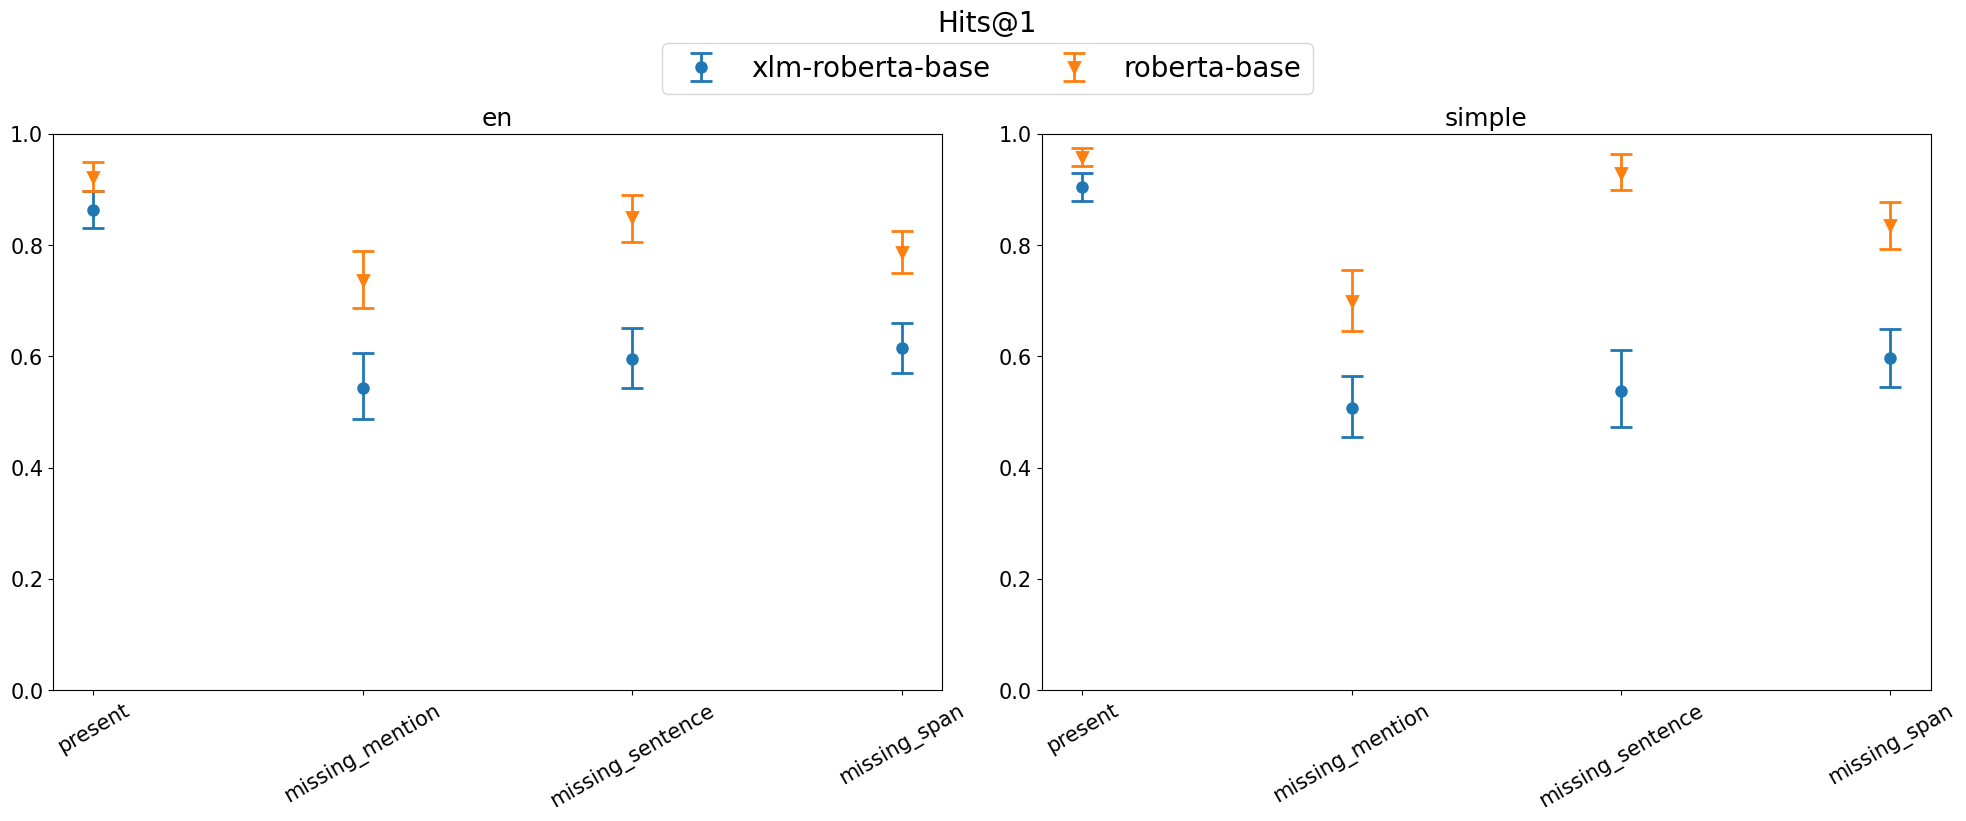

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Hits@1', fontsize=20, y=1.03)

for i, ax in enumerate(axs):
    for column, label, marker, colour in zip(columns[i], labels, markers, colours):
        if column in dfs[langs[i]].columns:
            # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
            y_points = [stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[langs[i]][column][s]['1']['score'] - stratified_hits_at_k[langs[i]][column][s]['1']['cl'][0] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies], [stratified_hits_at_k[langs[i]][column][s]['1']['cl'][1] - stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies]]
            ax.errorbar(strategies, y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=markersize, linestyle='None', elinewidth=2, markeredgewidth=2, color=colour)
            # set y axis limits (0-1)
            ax.set_ylim(0, 1)
            # set the title of each subplot to the language
            ax.set_title(langs[i])
            # rotate x labels
            ax.tick_params(axis='x', rotation=30)
            
# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles_, labels_ = axs[0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 1.005))

plt.tight_layout()

In [40]:
for column in columns[0]:
    for strategy in strategies:
        # print score and confidence interval for each strategy for each column
        print(f"{column} {strategy} MRR@max: {stratified_mrr_at_k['en'][column][strategy]['max']['score']} {stratified_mrr_at_k['en'][column][strategy]['max']['cl']}")
        print(f"{column} {strategy} Hits@1: {stratified_hits_at_k['en'][column][strategy]['1']['score']} {stratified_hits_at_k['en'][column][strategy]['1']['cl']}")

roberta_two_stage_rank_en present MRR@max: 0.892 [0.8630950645889472, 0.9180705094537815]
roberta_two_stage_rank_en present Hits@1: 0.863 [0.8308823529411765, 0.8970588235294118]
roberta_two_stage_rank_en missing_mention MRR@max: 0.63 [0.5806741722415951, 0.6842831491373668]
roberta_two_stage_rank_en missing_mention Hits@1: 0.543 [0.48717948717948717, 0.6051282051282051]
roberta_two_stage_rank_en missing_sentence MRR@max: 0.662 [0.6142705010522551, 0.7066437676150169]
roberta_two_stage_rank_en missing_sentence Hits@1: 0.595 [0.5422885572139303, 0.6517412935323383]
roberta_two_stage_rank_en missing_span MRR@max: 0.697 [0.6659873761877414, 0.7318853926703196]
roberta_two_stage_rank_en missing_span Hits@1: 0.615 [0.5692771084337349, 0.6596385542168675]
roberta_best_en present MRR@max: 0.936 [0.9135289487485757, 0.9588228266813426]
roberta_best_en present Hits@1: 0.923 [0.8970588235294118, 0.9485294117647058]
roberta_best_en missing_mention MRR@max: 0.797 [0.7591017341711785, 0.84089158783

In [43]:
from scipy.stats import ttest_ind
test_df = dfs['en']
# compute pair-wise p-values for each strategy
for i, column_1 in enumerate(columns[0]):
    for column_2 in columns[0][i+1:]:
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2)}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2)}")

roberta_two_stage_rank_en vs roberta_best_en for present
	MRR@max: TtestResult(statistic=-2.04226192818633, pvalue=0.04160898219175772, df=542.0)
	Hits@1: TtestResult(statistic=-2.2287872221774276, pvalue=0.026237320070032225, df=542.0)
roberta_two_stage_rank_en vs roberta_best_en for missing_mention
	MRR@max: TtestResult(statistic=-4.269452225840822, pvalue=2.4665756856964534e-05, df=388.0)
	Hits@1: TtestResult(statistic=-4.0861505766121615, pvalue=5.331645155613239e-05, df=388.0)
roberta_two_stage_rank_en vs roberta_best_en for missing_sentence
	MRR@max: TtestResult(statistic=-6.83584459186385, pvalue=3.0568853865688715e-11, df=400.0)
	Hits@1: TtestResult(statistic=-6.026985705139151, pvalue=3.796053664249604e-09, df=400.0)
roberta_two_stage_rank_en vs roberta_best_en for missing_span
	MRR@max: TtestResult(statistic=-5.490284964723105, pvalue=5.7232048676054226e-08, df=662.0)
	Hits@1: TtestResult(statistic=-4.908086033701197, pvalue=1.1593330974686116e-06, df=662.0)
